In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [13]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        # initialize action_prob
        action_prob = np.full(nA, epsilon/nA)
        best_a = np.argmax(Q[observation])
        action_prob[best_a] += (1.0 -epsilon)
        return action_prob
    return policy_fn

In [18]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # blank
    # update Q by Q[state][action] later
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i_e in range(1, num_episodes+1):
        if i_e % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_e, num_episodes), end="")
            sys.stdout.flush()
            
        episode = []
        state = env.reset()
        for t in range(100):
            action_prob = policy(state)
            # randomly choose action following probability of each action
            action = np.random.choice(np.arange(len(action_prob)), p = action_prob)
            
            next_state, reward, done, _ = env.step(action)
            
            episode.append((state, action, reward))
            if done:
                break
            
            state = next_state
        
        # get unique state action pairs
        state_action_pair = set((e[0], e[1]) for e in episode)
        for state_action in state_action_pair:
            state = state_action[0]
            action = state_action[1]
            
            # increase counter for the state action pair
            returns_count[state_action] += 1.0
            
            # find index of first occurrence of the state pair in the episode
            first_idx = 0
            for i, e in enumerate(episode):
                if e[0] == state and e[1] == action:
                    first_idx = i
                    break
            gain = 0
            for i, e in enumerate(episode[first_idx:]):
                gain += (discount_factor ** i) * e[2]
            returns_sum[state_action] += gain
            
            Q[state][action] = returns_sum[state_action]/returns_count[state_action]
    return Q, policy

In [19]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

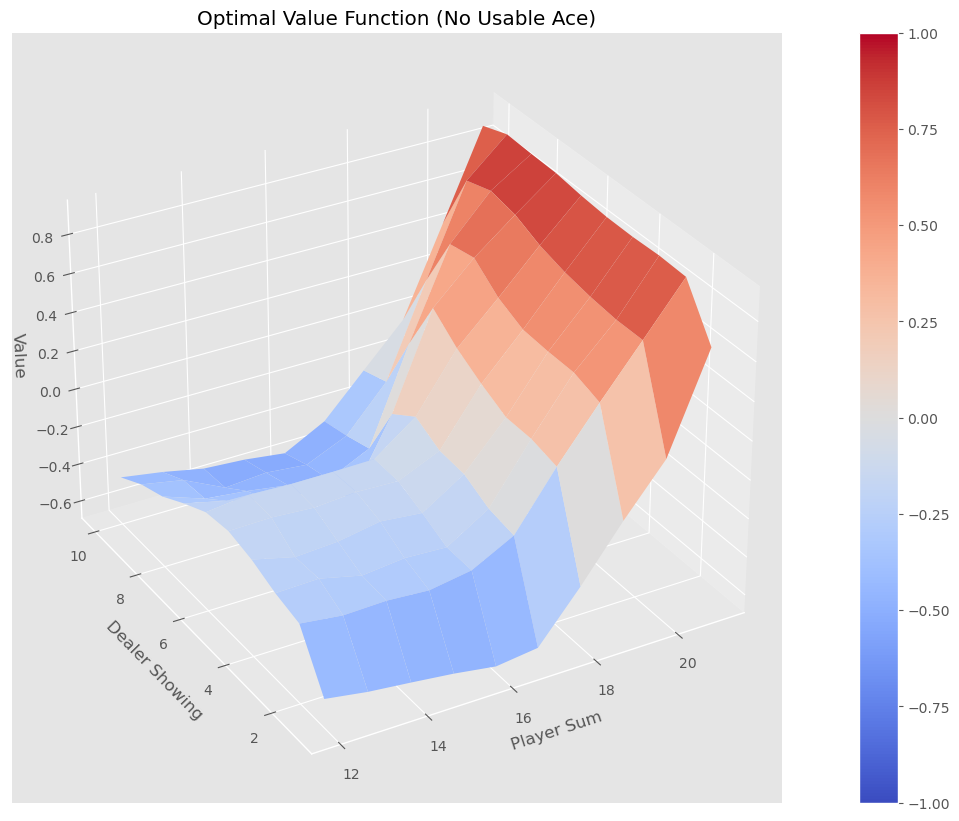

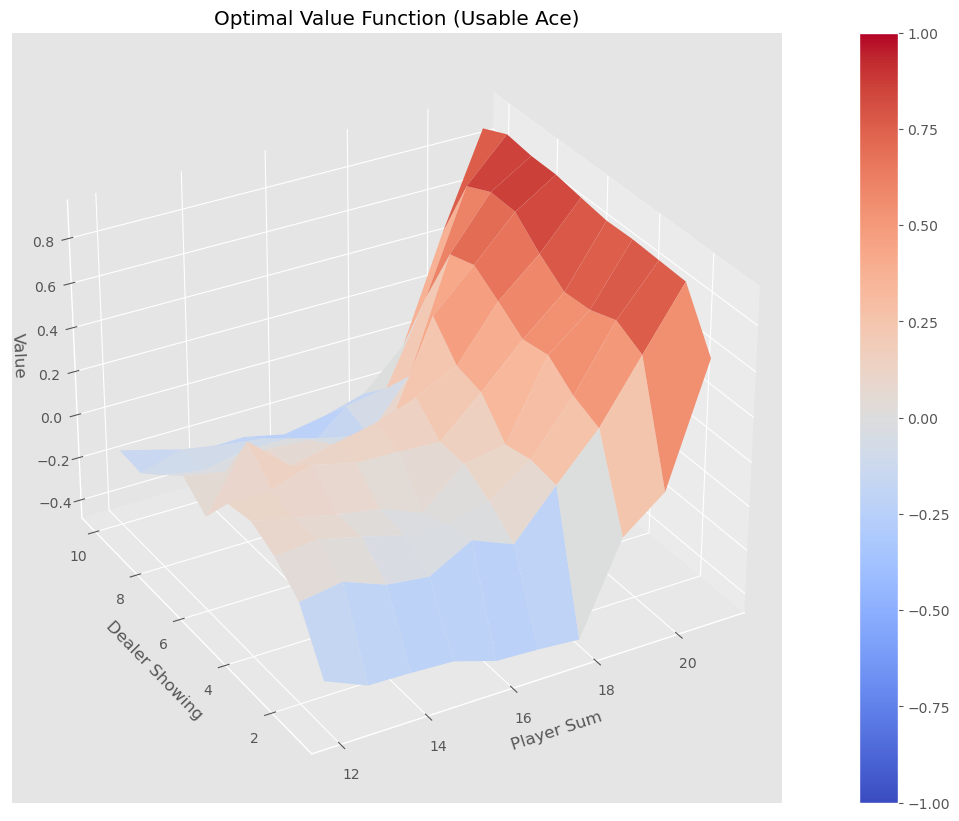

In [29]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")